# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
import datetime
from operator import itemgetter

import sqlalchemy as salc
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Repositories for OpenShift and Kubernetes

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github

repos_openshift = ['https://github.com/openshift/origin',
                  'https://github.com/openshift/source-to-image',
                  'https://github.com/openshift/openshift-ansible',
                  'https://github.com/openshift/osin',
                  'https://github.com/openshift/installer']

repos_kubernetes = ['https://github.com/kubernetes/kubernetes',
                   'https://github.com/kubernetes/minikube',
                   'https://github.com/kubernetes/kops',
                   'https://github.com/kubernetes/ingress-nginx',
                   'https://github.com/kubernetes/dashboard']

In [5]:
repo_set_openshift = []
repo_name_set_openshift = []
for repo_git in repos_openshift:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id,
                    b.repo_name
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_git = \'{repo_git}\'
        """)

    t = engine.execute(repo_query)
    results = t.mappings().all()[0]
    repo_id = results['repo_id']
    repo_name = results['repo_name']
    repo_set_openshift.append(repo_id)
    repo_name_set_openshift.append(repo_name)
print(repo_set_openshift)
print(repo_name_set_openshift)

[32413, 32390, 32537, 32408, 32010]
['origin', 'source-to-image', 'openshift-ansible', 'osin', 'installer']


In [6]:
repo_set_kubernetes = []
repo_name_set_kubernetes = []
for repo_git in repos_kubernetes:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id,
                    b.repo_name
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_git = \'{repo_git}\'
        """)

    t = engine.execute(repo_query)
    results = t.mappings().all()[0]
    repo_id = results['repo_id']
    repo_name = results['repo_name']
    repo_set_kubernetes.append(repo_id)
    repo_name_set_kubernetes.append(repo_name)
print(repo_set_kubernetes)
print(repo_name_set_kubernetes)

[27835, 27850, 27833, 27805, 27825]
['kubernetes', 'minikube', 'kops', 'ingress-nginx', 'dashboard']


In [7]:
repo_set = repo_set_kubernetes + repo_set_openshift
repo_name_set = repo_name_set_kubernetes + repo_name_set_openshift

In [8]:
# openshift_repos_ids = merged_df[merged_df['repo_name'].isin(repos_openshift)]['repo_id'].unique()
# kubernetes_repos_ids = merged_df[merged_df['repo_name'].isin(repos_kubernetes)]['repo_id'].unique()
# openshift_repos_names = merged_df[merged_df['repo_name'].isin(repos_openshift)]['repo_name'].unique()
# kubernetes_repos_names = merged_df[merged_df['repo_name'].isin(repos_kubernetes)]['repo_name'].unique()

# print(openshift_repos_ids)
# print(openshift_repos_names)
# print(kubernetes_repos_ids)
# print(kubernetes_repos_names)

https://developer.ibm.com/blogs/a-brief-history-of-red-hat-openshift/

### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [9]:
issue_contrib = pd.DataFrame()
for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                i.cntrb_id,
                i.issue_id,
                i.created_at
                FROM
                repo r, issues i
                 WHERE
                i.repo_id = \'{repo_id}\' AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])

issue_contrib = issue_contrib.reset_index()
issue_contrib.drop("index", axis=1, inplace=True)
issue_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'issue_id', 'created_at']
issue_contrib['cntrb_id'] = issue_contrib['cntrb_id'].astype('Int64')
display(issue_contrib)
issue_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,issue_id,created_at
0,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349183,2015-04-08 23:29:49
1,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349184,2015-04-08 23:21:29
2,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349185,2015-04-08 22:58:48
3,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349186,2015-04-08 22:46:37
4,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1349187,2015-04-08 22:28:38
...,...,...,...,...,...,...
101830,32010,https://github.com/openshift/installer,installer,<NA>,2625992,2022-06-02 17:35:19
101831,32010,https://github.com/openshift/installer,installer,<NA>,2625996,2022-06-01 13:42:47
101832,32010,https://github.com/openshift/installer,installer,<NA>,2625997,2022-05-31 16:42:18
101833,32010,https://github.com/openshift/installer,installer,<NA>,2626000,2022-05-30 14:14:36


repo_id                int64
repo_git              object
repo_name             object
cntrb_id               Int64
issue_id               int64
created_at    datetime64[ns]
dtype: object

In [10]:
issue_contrib['created_at_dt'] = issue_contrib['created_at'].dt.date

In [11]:
date_range = (issue_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (issue_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
issue_contrib = issue_contrib.loc[date_range]

In [12]:
issue_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,issue_id,created_at,created_at_dt
5452,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355520,2014-06-27 07:00:52,2014-06-27
5453,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355521,2014-06-27 03:26:47,2014-06-27
5454,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355522,2014-06-27 02:22:40,2014-06-27
5455,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355516,2014-06-27 21:26:35,2014-06-27
5456,27835,https://github.com/kubernetes/kubernetes,kubernetes,<NA>,1355517,2014-06-27 21:10:14,2014-06-27


### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [13]:
pr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                prm.cntrb_id,
                prm.pull_request_id,
                pr.pr_created_at
                FROM
                repo r, pull_request_meta prm, pull_requests pr
                WHERE
                prm.repo_id = \'{repo_id}\' AND
                prm.repo_id = r.repo_id AND
                prm.pull_request_id = pr.pull_request_id
                LIMIT 50000
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
pr_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'pull_request_id', 'pr_created_at']
pr_contrib['cntrb_id'] = pr_contrib['cntrb_id'].astype('Int64')
display(pr_contrib)
pr_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at
0,27835,https://github.com/kubernetes/kubernetes,kubernetes,2204694,173904,2019-08-14 17:09:20
1,27835,https://github.com/kubernetes/kubernetes,kubernetes,2206573,173904,2019-08-14 17:09:20
2,27835,https://github.com/kubernetes/kubernetes,kubernetes,2206229,173907,2019-08-14 18:36:38
3,27835,https://github.com/kubernetes/kubernetes,kubernetes,2206573,173907,2019-08-14 18:36:38
4,27835,https://github.com/kubernetes/kubernetes,kubernetes,2216925,173908,2019-08-14 18:50:42
...,...,...,...,...,...,...
150875,32010,https://github.com/openshift/installer,installer,2204295,642936,2021-10-18 20:26:06
150876,32010,https://github.com/openshift/installer,installer,2217663,642917,2021-04-22 05:36:18
150877,32010,https://github.com/openshift/installer,installer,163698,642928,2021-09-07 08:52:25
150878,32010,https://github.com/openshift/installer,installer,2204295,642928,2021-09-07 08:52:25


repo_id                     int64
repo_git                   object
repo_name                  object
cntrb_id                    Int64
pull_request_id             int64
pr_created_at      datetime64[ns]
dtype: object

In [14]:
pr_contrib['created_at_dt'] = pr_contrib['pr_created_at'].dt.date

In [15]:
date_range = (pr_contrib['created_at_dt'] > pd.to_datetime('2011-01-01')) & (pr_contrib['created_at_dt'] <= pd.to_datetime('2014-06-30'))
pr_contrib = pr_contrib.loc[date_range]

In [16]:
pr_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at,created_at_dt
138432,32390,https://github.com/openshift/source-to-image,source-to-image,2212145,366895,2014-01-28 20:37:52,2014-01-28
138433,32390,https://github.com/openshift/source-to-image,source-to-image,2204295,366895,2014-01-28 20:37:52,2014-01-28
138434,32390,https://github.com/openshift/source-to-image,source-to-image,2216894,366898,2014-01-29 16:16:04,2014-01-29
138435,32390,https://github.com/openshift/source-to-image,source-to-image,2204295,366898,2014-01-29 16:16:04,2014-01-29
138436,32390,https://github.com/openshift/source-to-image,source-to-image,2212145,366899,2014-01-29 16:32:48,2014-01-29


### Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [17]:
prr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                prr.cntrb_id,
                prr.pull_request_id,
                pr.pr_created_at
                FROM
                repo r, pull_request_reviews prr, pull_requests pr
                WHERE
                prr.repo_id = \'{repo_id}\' AND
                prr.repo_id = r.repo_id AND
                pr.pull_request_id = prr.pull_request_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    prr_contrib = pd.concat([prr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
prr_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'pull_request_id', 'pr_created_at']
prr_contrib['cntrb_id'] = prr_contrib['cntrb_id'].astype('Int64')
display(prr_contrib)
prr_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at


repo_id            object
repo_git           object
repo_name          object
cntrb_id            Int64
pull_request_id    object
pr_created_at      object
dtype: object

### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [18]:
commit_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                r.repo_name,
                ca.cntrb_id,
                c.cmt_id,
                c.cmt_date_attempted
                FROM
                repo r, commits c, contributors_aliases ca
                WHERE
                c.repo_id = \'{repo_id}\' AND
                c.repo_id = r.repo_id and
                c.cmt_committer_email = ca.alias_email
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

commit_contrib = commit_contrib.reset_index()
commit_contrib.drop("index", axis=1, inplace=True)
commit_contrib.columns =['repo_id', 'repo_git', 'repo_name', 'cntrb_id', 'cmt_id', 'cmt_date_attempted']
commit_contrib['cntrb_id'] = commit_contrib['cntrb_id'].astype('Int64')
display(commit_contrib)
commit_contrib.dtypes

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted
0,27835,https://github.com/kubernetes/kubernetes,kubernetes,2205542,88537913,2017-08-07
1,27835,https://github.com/kubernetes/kubernetes,kubernetes,2272203,87499930,2015-07-13
2,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558362,2014-06-12
3,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558364,2014-06-12
4,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558366,2014-06-12
...,...,...,...,...,...,...
1786255,32010,https://github.com/openshift/installer,installer,2206298,117019342,2019-08-07
1786256,32010,https://github.com/openshift/installer,installer,2206298,117019343,2019-08-07
1786257,32010,https://github.com/openshift/installer,installer,2206298,117019344,2019-08-07
1786258,32010,https://github.com/openshift/installer,installer,2206298,117018681,2019-08-08


repo_id                        int64
repo_git                      object
repo_name                     object
cntrb_id                       Int64
cmt_id                         int64
cmt_date_attempted    datetime64[ns]
dtype: object

In [19]:
commit_contrib['cmt_date_attempted_dt'] = commit_contrib['cmt_date_attempted'].dt.date

In [20]:
date_range = (commit_contrib['cmt_date_attempted_dt'] > pd.to_datetime('2011-01-01')) & (commit_contrib['cmt_date_attempted_dt'] <= pd.to_datetime('2014-06-30'))
commit_contrib = commit_contrib.loc[date_range]

In [21]:
commit_contrib.head()

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted,cmt_date_attempted_dt
2,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558362,2014-06-12,2014-06-12
3,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558364,2014-06-12,2014-06-12
4,27835,https://github.com/kubernetes/kubernetes,kubernetes,67879,88558366,2014-06-12,2014-06-12
515,27835,https://github.com/kubernetes/kubernetes,kubernetes,39204,88566373,2014-06-24,2014-06-24
516,27835,https://github.com/kubernetes/kubernetes,kubernetes,39204,88844282,2014-06-28,2014-06-28


## Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributor Graph

In [22]:
df_commit = commit_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id,28077,29906,33047,39204,57925,63341,67879,91233,181894,1990916,...,2288616,2288808,2288850,2288859,2288875,2288877,2288883,2288888,2390787,2506096
repo_name,,,,,,,,,,,,,,,,,,,,,
installer,6,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kubernetes,0,1,1,71,0,0,3,3,0,1353,...,1,42,1,1,1,1,1,2,9,555
osin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
source-to-image,0,0,0,0,4,0,0,0,11,0,...,0,0,0,0,0,0,0,0,0,0


In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [23]:
df_commit = df_commit.reset_index()

In [24]:
df_commit.head()

cntrb_id,repo_name,28077,29906,33047,39204,57925,63341,67879,91233,181894,...,2288616,2288808,2288850,2288859,2288875,2288877,2288883,2288888,2390787,2506096
0,installer,6,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,kubernetes,0,1,1,71,0,0,3,3,0,...,1,42,1,1,1,1,1,2,9,555
2,osin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,source-to-image,0,0,0,0,4,0,0,0,11,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df_melted_commit = df_commit.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [26]:
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

,repo_name,cntrb_id,number
0,installer,28077,6
5,kubernetes,29906,1
9,kubernetes,33047,1
13,kubernetes,39204,71
19,source-to-image,57925,4


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

#### Create melted dataframes for all contribution type dataframes

In [27]:
def created_melted_dfs(df):

    df = df.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
    df = df.reset_index()

    df_melted = df.melt(['repo_name'], var_name = 'cntrb_id',value_name='number')
    df_melted = df_melted[df_melted[df_melted.columns[2]] != 0]
    
    return df_melted

In [28]:
df_melted_pr_contrib = created_melted_dfs(pr_contrib)
df_melted_pr_contrib.head()

,repo_name,cntrb_id,number
1,source-to-image,127041,5
2,osin,144547,1
5,source-to-image,172472,2
7,source-to-image,181894,3
9,source-to-image,1997194,1


In [29]:
df_melted_issue_contrib = created_melted_dfs(issue_contrib)
df_melted_issue_contrib.head()

,repo_name,cntrb_id,number
1,source-to-image,57925,2
3,source-to-image,127041,2
5,source-to-image,181894,1
7,source-to-image,2204263,1
9,source-to-image,2204329,10


### Join repositories of all contribution types

Combine dataframes of Issue contributors, PR contributors, PR Reviewers, and Commit Contributors to get aggregated contributor dataframes for each repository

In [30]:
commit_issue = pd.merge(df_melted_commit, df_melted_issue_contrib, how="outer", on=["repo_name", "cntrb_id"])

In [31]:
merged_df = pd.merge(df_melted_pr_contrib, commit_issue, how="outer", on=["repo_name", "cntrb_id"])

In [32]:
col_list= ['number', 'number_x', 'number_y']
merged_df['total_contributions'] = merged_df[col_list].sum(axis=1)
merged_df.drop(col_list, axis=1, inplace=True)

In [33]:
merged_df.head()

,repo_name,cntrb_id,total_contributions
0,source-to-image,127041.0,7.0
1,osin,144547.0,1.0
2,source-to-image,172472.0,2.0
3,source-to-image,181894.0,15.0
4,source-to-image,1997194.0,4.0


### Create Graphs

In [34]:
G = nx.from_pandas_edgelist(merged_df, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='total_contributions',
                            create_using=nx.MultiDiGraph())

In [35]:
nodes = G.nodes()

In [36]:
Repo_name = merged_df['repo_name'].to_list()
contributor_id = merged_df['cntrb_id'].to_list()

In [37]:
colors = []
for n in nodes:
    if n in repo_name_set_kubernetes:
        colors.append('blue')
    elif n in repo_name_set_openshift:
        colors.append('green')
    else:
        colors.append('yellow')

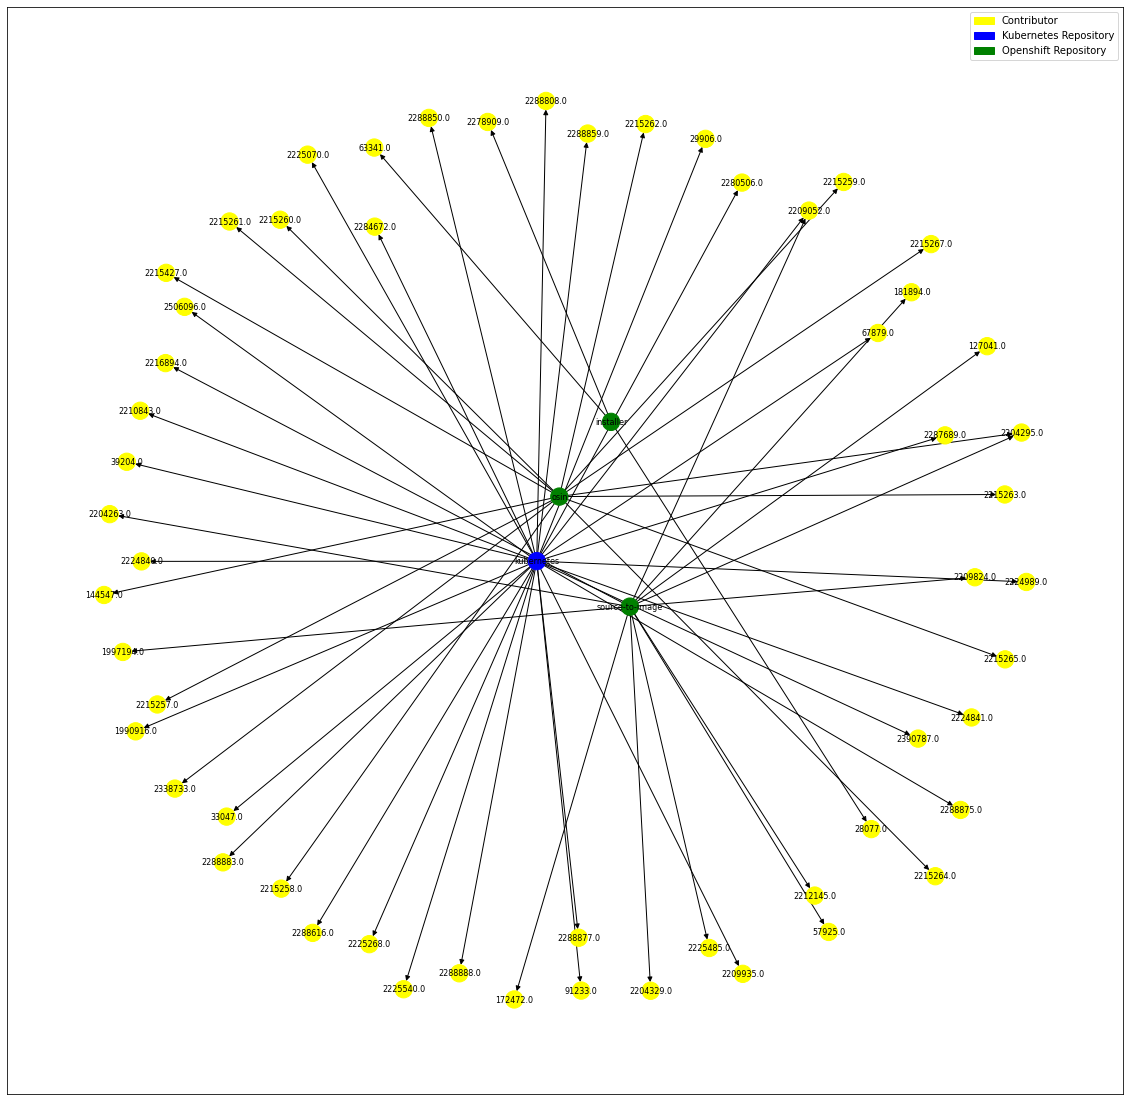

In [38]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repository')
green_patch = mpatches.Patch(color='green', label='Openshift Repository')
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### Use PageRank and Betweenness Centrality to Subset Nodes

We can now try to run the `PageRank` algorithm to compute the ranking of the nodes in the graph based on the structure of the incoming links. In order to run the PageRank algorithm we will need to convert the undirected graph to a directed graph by adding two edges for each edge. The PageRank algorithm will help us identify the "top repositories".

We will also look into the betweenness centrality in the graph to compute the shortest-path betweenness centrality for nodes. It measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

In [39]:
#Convert G to directed graph
H = nx.DiGraph(G)

In [40]:
nodes = H.nodes()
colors = []
for n in nodes:
    if n in repo_name_set_kubernetes:
        colors.append('blue')
    elif n in repo_name_set_openshift:
        colors.append('green')
    else:
        colors.append('yellow')

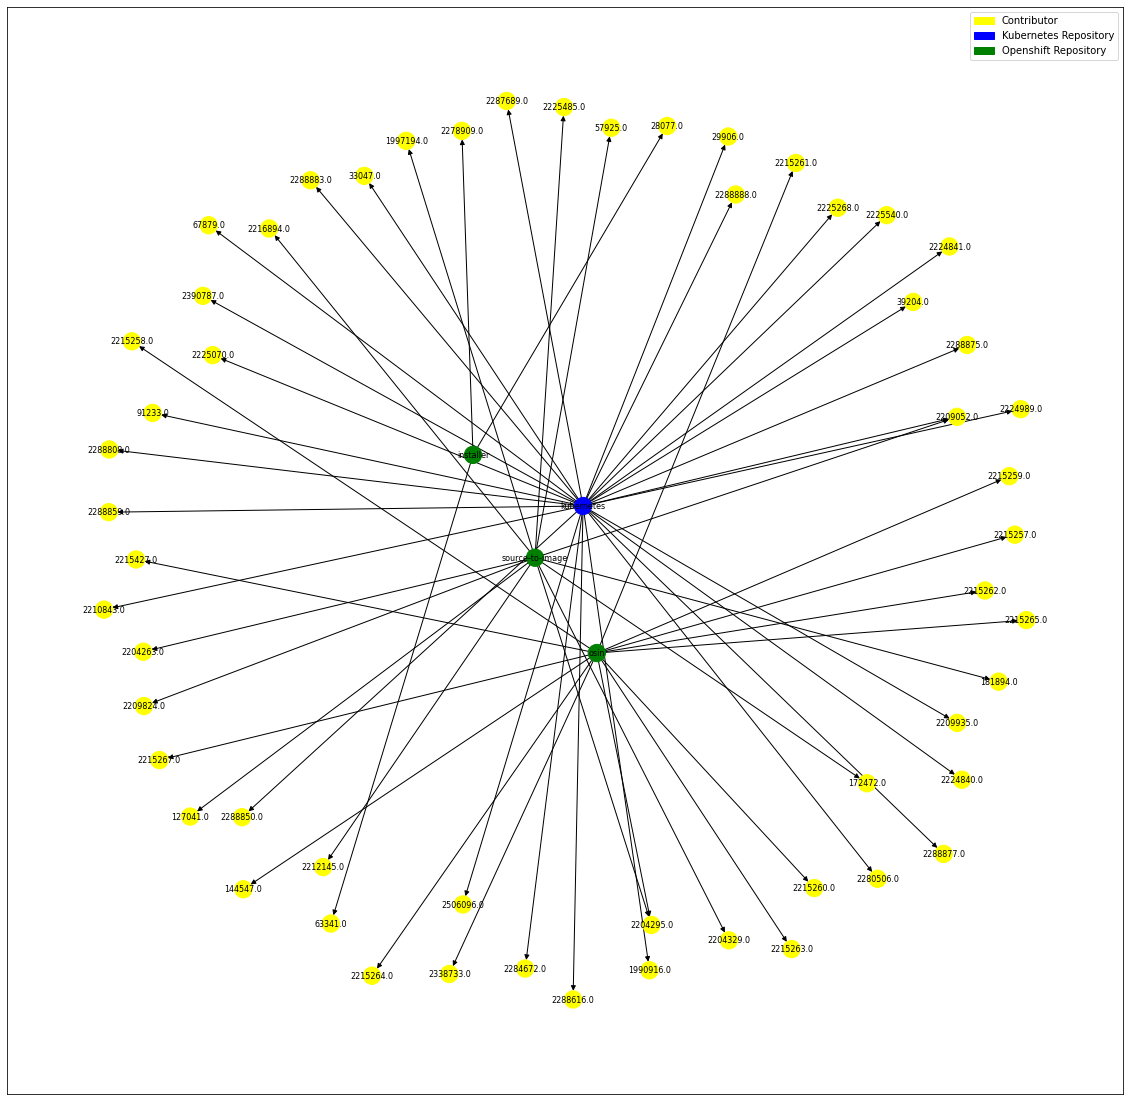

In [41]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repository')
green_patch = mpatches.Patch(color='green', label='Openshift Repository')
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(H, node_color=colors, font_size=8, ax=ax)

### Page Rank

In [42]:
pageranks = nx.pagerank(H, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight='weight', dangling=None)

The first input parameter of the method, H, is the NetworkX graph. Undirected graphs will be converted to a directed graph with two directed edges for each undirected edge. The second parameter, alpha, is the damping parameter for PageRank and the default value is 0.85. The fourth parameter, max_iter, is the Maximum number of iterations. The seventh parameter, weight, represents the edge attribute that should be used as the edge weight. If it’s not specified, the weight of all edges will be 1.

In [52]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = False)[:50])

We want to give higher priority to outgoing nodes. So we take 50 nodes with lowest pagerank

In [53]:
key = topnodes.keys()

In [54]:
subgraph = nx.subgraph(H, key)

In [55]:
subgraph

In [56]:
nodes = subgraph.nodes()
colors = []
for n in nodes:
    if n in repo_name_set_kubernetes:
        colors.append('blue')
    elif n in repo_name_set_openshift:
        colors.append('green')
    else:
        colors.append('yellow')

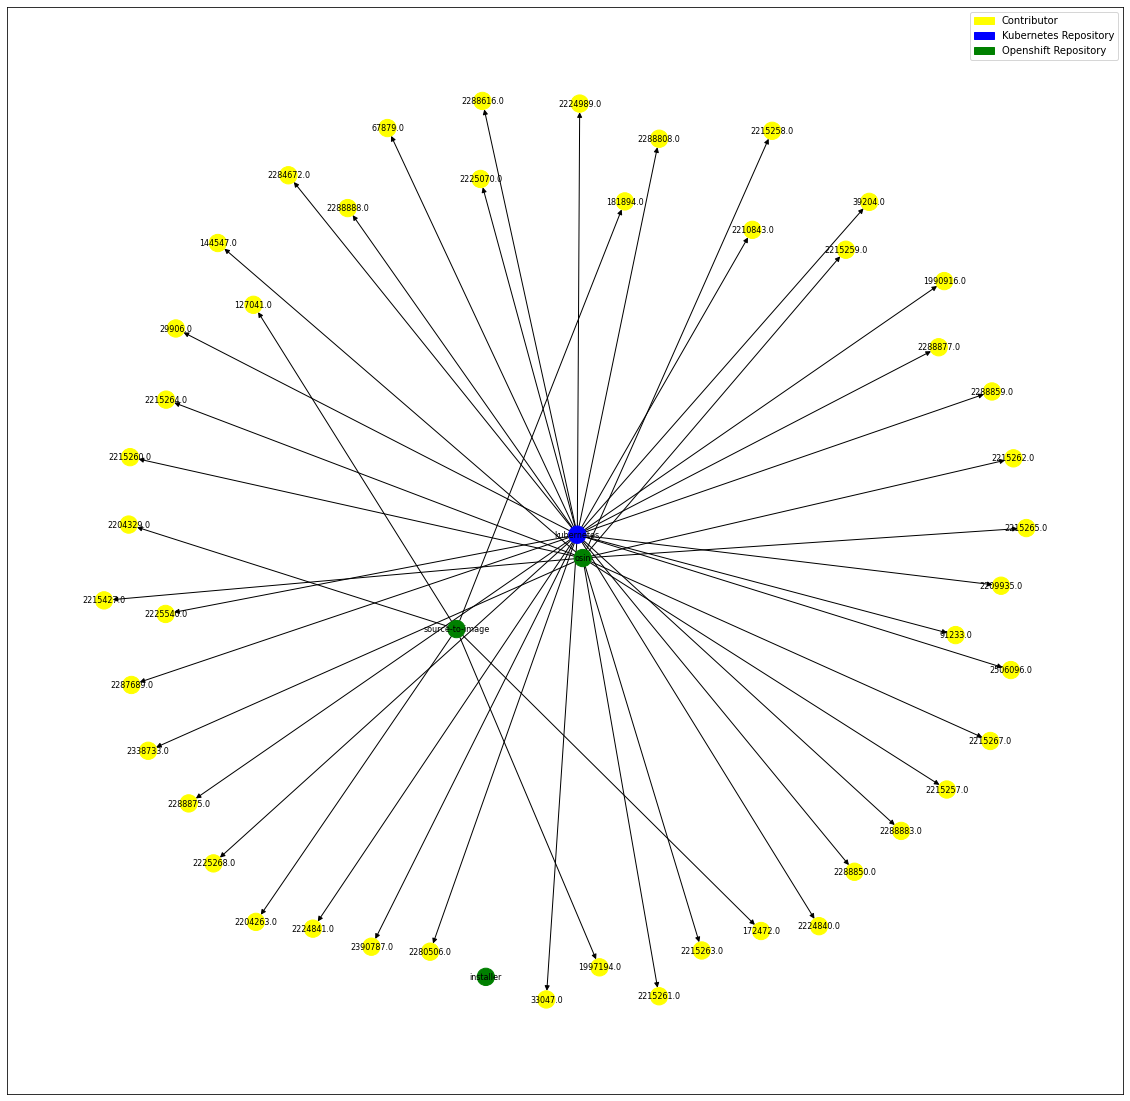

In [57]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Kubernetes Repository')
green_patch = mpatches.Patch(color='green', label='Openshift Repository')
ax.legend(handles=[yellow_patch, blue_patch, green_patch])
nx.draw_networkx(subgraph, node_color=colors, font_size=8, ax=ax)

### Betweenness centrality

In [58]:
centrality = nx.betweenness_centrality(H)

In [59]:
centrality

{'source-to-image': 0.0,
 127041.0: 0.0,
 'osin': 0.0,
 144547.0: 0.0,
 172472.0: 0.0,
 181894.0: 0.0,
 1997194.0: 0.0,
 2204263.0: 0.0,
 2204295.0: 0.0,
 2204329.0: 0.0,
 2209052.0: 0.0,
 2209824.0: 0.0,
 2212145.0: 0.0,
 2215257.0: 0.0,
 2215258.0: 0.0,
 2215259.0: 0.0,
 2215260.0: 0.0,
 2215261.0: 0.0,
 2215262.0: 0.0,
 2215263.0: 0.0,
 2215264.0: 0.0,
 2215265.0: 0.0,
 2215427.0: 0.0,
 2216894.0: 0.0,
 'installer': 0.0,
 28077.0: 0.0,
 'kubernetes': 0.0,
 29906.0: 0.0,
 33047.0: 0.0,
 39204.0: 0.0,
 57925.0: 0.0,
 63341.0: 0.0,
 67879.0: 0.0,
 91233.0: 0.0,
 1990916.0: 0.0,
 2209935.0: 0.0,
 2210843.0: 0.0,
 2224840.0: 0.0,
 2224841.0: 0.0,
 2224989.0: 0.0,
 2225070.0: 0.0,
 2225268.0: 0.0,
 2225540.0: 0.0,
 2278909.0: 0.0,
 2280506.0: 0.0,
 2284672.0: 0.0,
 2287689.0: 0.0,
 2288616.0: 0.0,
 2288808.0: 0.0,
 2288850.0: 0.0,
 2288859.0: 0.0,
 2288875.0: 0.0,
 2288877.0: 0.0,
 2288883.0: 0.0,
 2288888.0: 0.0,
 2390787.0: 0.0,
 2506096.0: 0.0,
 2215267.0: 0.0,
 2225485.0: 0.0,
 233873

For this case all are zero cause maybe we only picked 10 repositories. With more repos there might be more nodes that lie in between nodes and might be useful there.

## Nodes as projects edges as contributors

In this section, we represent data in a different way and try out another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

In [60]:
merged_df.head()

,repo_name,cntrb_id,total_contributions
0,source-to-image,127041.0,7.0
1,osin,144547.0,1.0
2,source-to-image,172472.0,2.0
3,source-to-image,181894.0,15.0
4,source-to-image,1997194.0,4.0


In [65]:
contributorGraph = {}
for i, row in merged_df.iterrows():
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    if(row['total_contributions'] > 0):
        contributorGraph[row['cntrb_id']].append((row['repo_name'], row['total_contributions']))

In [66]:
list(contributorGraph.items())[:10]

[(127041.0, [('source-to-image', 7.0)]),
 (144547.0, [('osin', 1.0)]),
 (172472.0, [('source-to-image', 2.0)]),
 (181894.0, [('source-to-image', 15.0)]),
 (1997194.0, [('source-to-image', 4.0)]),
 (2204263.0, [('source-to-image', 4.0)]),
 (2204295.0, [('osin', 15.0), ('source-to-image', 61.0)]),
 (2204329.0, [('source-to-image', 95.0)]),
 (2209052.0, [('source-to-image', 4.0), ('kubernetes', 1.0)]),
 (2209824.0, [('source-to-image', 2.0)])]

`contributorGraph` above is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of **"shared connections"** between them. Lets explain **"connected"** repositories and shared "connections".

structure of `contributorGraph` =  
{  
`repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
 `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [67]:
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
print(commonRepoContributionsByContributor)

defaultdict(<class 'int'>, {('osin', 'source-to-image'): 76.0, ('source-to-image', 'kubernetes'): 5.0})


`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [68]:
res = []
for key in commonRepoContributionsByContributor:
    res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [69]:
g = nx.Graph()
g.add_weighted_edges_from(res)

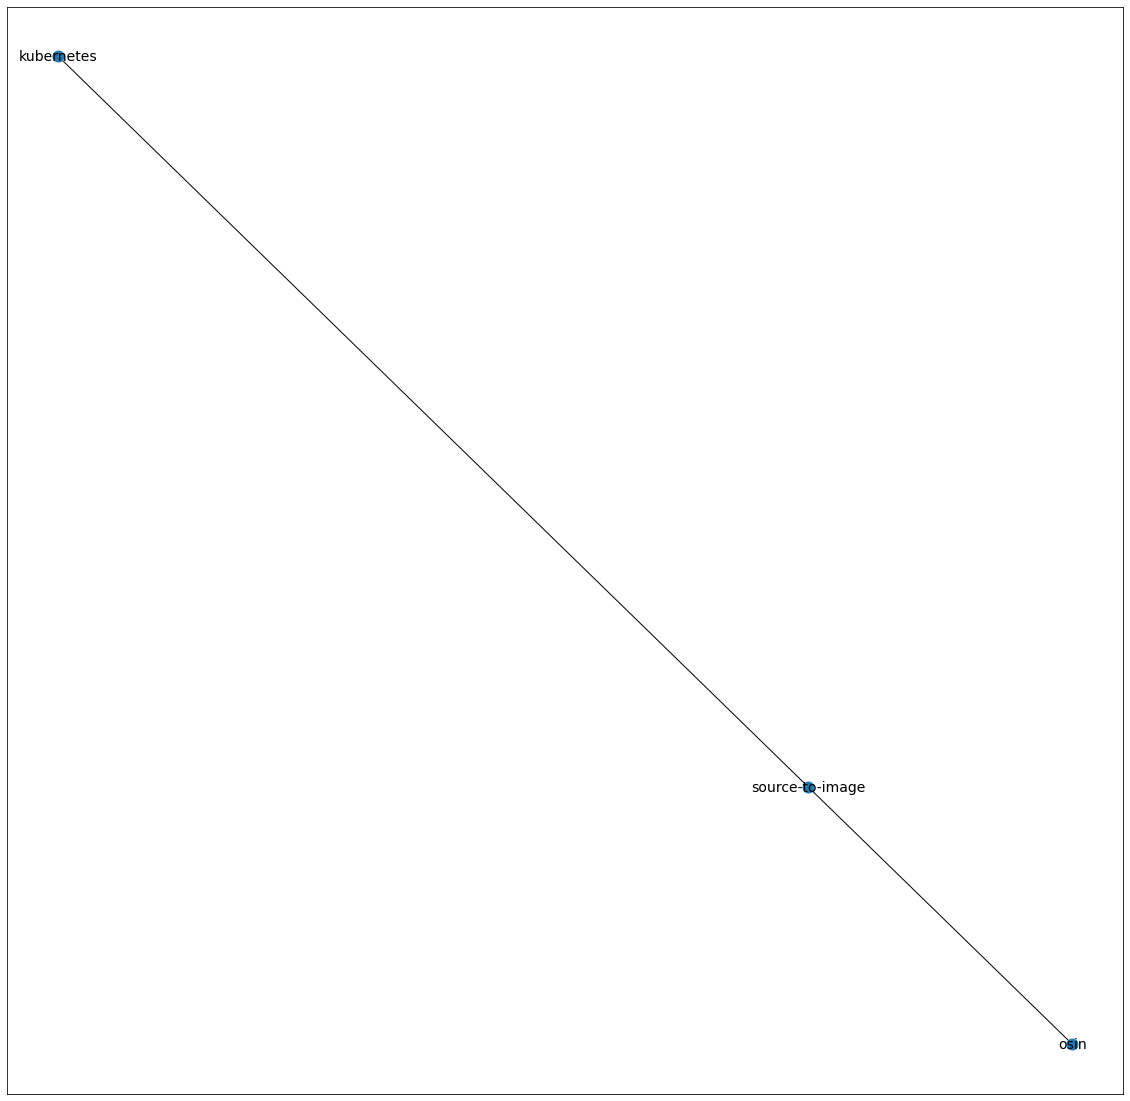

In [70]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx(g, node_size=120, font_size=14, ax=ax)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. See above for the definition of **"connected"** 

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.